In [177]:
# Australian Geoscience Datacube
## Feature Summary Examples

The [Australian Geoscience Datacube](https://github.com/data-cube/agdc-v2) provides an integrated gridded data analysis environment for decades of analysis ready earth observation satellite and related data from multiple satellite and other acquisition systems.

For instructions on using the Datacube on NCI, see: http://agdc-v2.readthedocs.io/en/develop/nci_usage.html

For instructions on setting up your own instance, see: http://agdc-v2.readthedocs.io/en/develop/install.html

This notebook touches briefly on some the implimented features of the Datacube module, and is only intended to deomstrat functionality rather than be a tutorial.

In [173]:
%pylab notebook
#%pylab inline
#%matplotlib inline
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
import json
import pandas as pd
from IPython.display import display
import ipywidgets as widgets
import fiona
import shapely
import shapely.geometry
from shapely.geometry import shape
import rasterio
import matplotlib.gridspec as gridspec


Populating the interactive namespace from numpy and matplotlib


/g/data/v10/public/modules/agdc-py2-env/20160906/envs/agdc/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


If you have set up your config correctly, or are using the module on NCI, you should be able to make `Datacube` object that can connects to the configured datacube system.

In [3]:
dc = datacube.Datacube(app='dc-example')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://lxl554@130.56.244.227:6432/datacube)>>>

## Datacube products and measurements
The Datacube provides pandas.DataFrame representations of the available products and measurements:

In [241]:
#dc.list_products()

## Datacube Measurements
The list of measurements stored in the datacube can also be listed.

Measurements are also known as _bands_ in the imagery domain, and _data variables_ when stored in NetCDF files or when working with `xarray.Dataset` objects.

In [5]:
#dc.list_measurements()

In [6]:
def geom_query(geom, geom_crs='EPSG:4326'):
    """
    Create datacube query snippet for geometry
    """
    return {
        'x': (geom.bounds[0], geom.bounds[2]),
        'y': (geom.bounds[1], geom.bounds[3]),
        'crs': geom_crs
    }


def warp_geometry(geom, crs_crs, dst_crs):
    """
    warp geometry from crs_crs to dst_crs
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(crs_crs, dst_crs, shapely.geometry.mapping(geom)))


def transect(data, geom, resolution, method='nearest', tolerance=None):
    """
    
    """
    dist = [i for i in range(0, int(geom.length), resolution)]
    points = zip(*[geom.interpolate(d).coords[0] for d in dist])
    indexers = {
        data.crs.dimensions[0]: list(points[1]),
        data.crs.dimensions[1]: list(points[0])        
    }
    return data.sel_points(xr.DataArray(dist, name='distance', dims=['distance']),
                           method=method,
                           tolerance=tolerance,
                           **indexers)

In [325]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords
#Either as polygon or as lat/lon range


vec_fname = '/g/data/r78/lxl554/hovmoller/thirlmere_aoi.shp' #comment these lines out if running without polygon
src = fiona.open(vec_fname)
geom = shape(src[0]['geometry'])




#Define temporal range
start_of_epoch = '1987-01-01'
#need a variable here that defines a rolling 'latest observation'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     'green',
                     'red', 
                     'nir',
                     'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensor1 = 'ls8'
sensor2 = 'ls7'
sensor3 = 'ls5'

query = {
    'time': (start_of_epoch, end_of_epoch),
}

query.update(geom_query(geom)) #comment this out if not using a polygon

#If not using a polygon/polyline, enter lat/lon here manually
"""lat_max = -32.83
lat_min = -32.86
lon_max = 147.55
lon_min = 147.45
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'"""

"lat_max = -32.83\nlat_min = -32.86\nlon_max = 147.55\nlon_min = 147.45\nquery['x'] = (lon_min, lon_max)\nquery['y'] = (lat_max, lat_min)\nquery['crs'] = 'EPSG:4326'"

In [326]:
print query

{'y': (-34.23533334956582, -34.21302281376028), 'x': (150.5133776115942, 150.5520257574438), 'crs': 'EPSG:4326', 'time': ('1987-01-01', '2016-12-31')}


## Retrieve surface reflectance data


In [327]:
#Group PQ by solar day to avoid idiosyncracies of N/S overlap differences in PQ algorithm performance
pq_albers_product = dc.index.products.get_by_name(sensor1+'_pq_albers')
valid_bit = pq_albers_product.measurements['pixelquality']['flags_definition']['contiguous']['bits']

def pq_fuser(dest, src):
    valid_val = (1 << valid_bit)

    no_data_dest_mask = ~(dest & valid_val).astype(bool)
    np.copyto(dest, src, where=no_data_dest_mask)

    both_data_mask = (valid_val & dest & src).astype(bool)
    np.copyto(dest, src & dest, where=both_data_mask)

In [328]:
#load sensor specific band adjustment tuples for TSS and brightness

In [329]:
#load sensor specific band adjustment tuples for TSS 
ls5_tss_constant = 3983
ls5_tss_exponent = 1.6246
ls7_tss_constant = 3983
ls7_tss_exponent = 1.6246
ls8_tss_constant = 3957
ls8_tss_exponent = 1.6436

# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [330]:
#Retrieve the NBAR and PQ data for sensor n
sensor1_nbar = dc.load(product= sensor1+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor1_pq = dc.load(product= sensor1+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
            

In [331]:
crs = sensor1_nbar.crs
crswkt = sensor1_nbar.crs.wkt

affine = sensor1_nbar.affine

In [332]:
crswkt

'PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]'

In [333]:
affine

Affine(25.0, 0.0, 1691725.0,
       0.0, -25.0, -3857300.0)

In [334]:
#This line exists to make sure that there's a 1:1 match between NBAR and PQ
sensor1_nbar = sensor1_nbar.sel(time = sensor1_pq.time)

In [335]:
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
#Generate PQ masks and apply those masks to remove cloud, cloud shadow, saturated observations
s1_cloud_free = masking.make_mask(sensor1_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s1_good_data = s1_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor1_nbar = sensor1_nbar.where(s1_good_data)

In [336]:
#Fix the TSS coefficients for each sensor
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR','NDWI','TSS']
sensor1_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor1_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor1_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor1_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor1_rsindex['NDVI'] = ((sensor1_nbar['nir']-sensor1_nbar['red'])/(sensor1_nbar['nir']+sensor1_nbar['red']))
    sensor1_rsindex['NDWI'] = ((sensor1_nbar['swir1']-sensor1_nbar['green'])/(sensor1_nbar['swir1']+sensor1_nbar['green']))
    #sensor1_rsindex['NBR'] = ((sensor1_nbar['nir']-sensor1_nbar['swir2'])/(sensor1_nbar['nir']+sensor1_nbar['swir2']))
    #Need this to reference into a tuple - Check with Damien    
    sensor1_rsindex['TSS'] = (ls8_tss_constant*((sensor1_nbar['green']+sensor1_nbar['red'])/20000)**ls8_tss_exponent)

In [337]:
sensor2_nbar = dc.load(product= sensor2+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor2_pq = dc.load(product= sensor2+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [338]:
sensor2_nbar = sensor2_nbar.sel(time = sensor2_pq.time)

In [339]:
s2_cloud_free = masking.make_mask(sensor2_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s2_good_data = s2_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor2_nbar = sensor2_nbar.where(s2_good_data)

In [340]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor2_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor2_rsindex['NDVI'] = ((sensor2_nbar['nir']-sensor2_nbar['red'])/(sensor2_nbar['nir']+sensor2_nbar['red']))
    sensor2_rsindex['NDWI'] = ((sensor2_nbar['swir1']-sensor2_nbar['green'])/(sensor2_nbar['swir1']+sensor2_nbar['green']))
    #sensor2_rsindex['NBR'] = ((sensor2_nbar['nir']-sensor2_nbar['swir2'])/(sensor2_nbar['nir']+sensor2_nbar['swir2']))
    sensor2_rsindex['TSS'] = (ls7_tss_constant*((sensor2_nbar['green']+sensor2_nbar['red'])/20000)**ls7_tss_exponent)


In [341]:
sensor3_nbar = dc.load(product= sensor3+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
sensor3_pq = dc.load(product= sensor3+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)                  

In [342]:
sensor3_nbar = sensor3_nbar.sel(time = sensor3_pq.time)

In [343]:
s3_cloud_free = masking.make_mask(sensor3_pq, 
                              cloud_acca='no_cloud',
                              cloud_shadow_acca = 'no_cloud_shadow',
                              cloud_shadow_fmask = 'no_cloud_shadow',
                              cloud_fmask='no_cloud',
                              blue_saturated = False,
                              green_saturated = False,
                              red_saturated = False,
                              nir_saturated = False,
                              swir1_saturated = False,
                              swir2_saturated = False,
                              contiguous=True)
s3_good_data = s3_cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
sensor3_nbar = sensor3_nbar.where(s3_good_data)

In [344]:
all_indices = [#'BRIGHT','GREEN','WET',
               'NDVI','NBR', 'NDWI','TSS']
sensor3_rsindex = {}
for i, name in enumerate(all_indices):
    #sensor2_rsindex['BRIGHT'] = pd.DataFrame((s1[0]*0.3037)+(s1[1]*0.2793)+(s1[2]*0.4343)+(s1[3]*0.5585)+(s1[4]*0.5082)+(s1[0]*0.1863))
    #sensor2_rsindex['GREEN'] = pd.DataFrame((s1[0]*-0.2848)+(s1[1]*-0.2435)+(s1[2]*-0.5436)+(s1[3]*0.7243)+(s1[4]*0.0840)+(s1[0]*-0.1800))
    #sensor2_rsindex['WET'] = pd.DataFrame((s1[0]*0.1509)+(s1[1]*0.1793)+(s1[2]*0.3299)+(s1[3]*0.3406)+(s1[4]*-0.7112)+(s1[0]*-0.4572))
    sensor3_rsindex['NDVI'] = ((sensor3_nbar['nir']-sensor3_nbar['red'])/(sensor3_nbar['nir']+sensor3_nbar['red']))
    sensor3_rsindex['NDWI'] = ((sensor3_nbar['swir1']-sensor3_nbar['green'])/(sensor3_nbar['swir1']+sensor3_nbar['green']))
    #sensor3_rsindex['NBR'] = ((sensor3_nbar['nir']-sensor3_nbar['swir2'])/(sensor3_nbar['nir']+sensor3_nbar['swir2']))
    #sensor3_rsindex['TSS'] = ((sensor3_nbar['green']+sensor3_nbar['red'])/2)
    sensor3_rsindex['TSS'] = (ls5_tss_constant*((sensor3_nbar['green']+sensor3_nbar['red'])/20000)**ls5_tss_exponent)


## Combining data from multiple sensors
Having masked out cloud and cloud shadow affected pixels and calculated various indices we can now combine the measurements from the different sensors to create full depth time series

In [345]:
#Concatenate and sort the different sensor xarrays into a single xarray

nbar_clean = xr.concat([sensor1_nbar, sensor2_nbar, sensor3_nbar], dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

all_tss_sorted = xr.concat([sensor1_rsindex['TSS'], sensor2_rsindex['TSS'], sensor3_rsindex['TSS']], dim='time')
time_sorted = all_tss_sorted.time.argsort()
all_tss_sorted = all_tss_sorted.isel(time=time_sorted)
all_tss_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

all_ndvi_sorted = xr.concat([sensor1_rsindex['NDVI'], sensor2_rsindex['NDVI'], sensor3_rsindex['NDVI']], dim='time')
time_sorted = all_ndvi_sorted.time.argsort()
all_ndvi_sorted = all_ndvi_sorted.isel(time=time_sorted)
all_ndvi_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

"""all_nbr_sorted = xr.concat([sensor1_rsindex['NBR'], sensor2_rsindex['NBR'], sensor3_rsindex['NBR']], dim='time')
time_sorted = all_nbr_sorted.time.argsort()
all_nbr_sorted = all_nbr_sorted.isel(time=time_sorted)
all_nbr_sorted.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine
"""

all_ndwi_sorted = xr.concat([sensor1_rsindex['NDWI'], sensor2_rsindex['NDWI'], sensor3_rsindex['NDWI']], dim='time')
time_sorted = all_ndwi_sorted.time.argsort()
all_ndwi_sorted = all_ndwi_sorted.isel(time=time_sorted)
all_ndwi_sorted.attrs['crs'] = crs
all_ndwi_sorted.attrs['affine'] = affine




In [346]:
#clean up per sensor xarrays to free up some memory
del sensor1_nbar
del sensor2_nbar
del sensor3_nbar
del sensor1_rsindex
del sensor2_rsindex
del sensor3_rsindex

In [347]:
query['crs']

'EPSG:4326'

In [348]:
all_tss_sorted.crs

CRS('EPSG:3577')

In [349]:
geom_w = warp_geometry(geom, query['crs'], crs.wkt)
trans = transect(all_tss_sorted, geom_w, 25)
#trans_drop = transect(all_tss_sorted, geom_w, 25).dropna('time', how = 'any')
#trans_drop = transect(all_tss_sorted, geom_w, 25).dropna('distance', how = 'any')
trans_drop = transect(all_ndvi_sorted, geom_w, 25).dropna('time', how = 'any', thresh = 90)

print trans_drop.shape
print trans.shape

(283, 680)
(283, 995)


In [271]:
trans_drop.plot(x='distance', y='time', vmin = 0, vmax = 1, yincrease = False)

The returned data is an `xarray.Dataset` object, which is a labelled n-dimensional array wrapping a `numpy` array.

We can investigate the data to see the variables (measurement bands) and dimensions that were returned:

## Plotting a multi-band image

In [350]:
print 'The number of time slices at this location is' 
print nbar_clean.red.shape[0]

The number of time slices at this location is
995


In [355]:
#select time slice of interest
time_slice_i = 551
rgb = nbar_clean.isel(time =time_slice_i).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 4500
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

#imshow(scaled, interpolation = 'nearest')

<IPython.core.display.Javascript object>


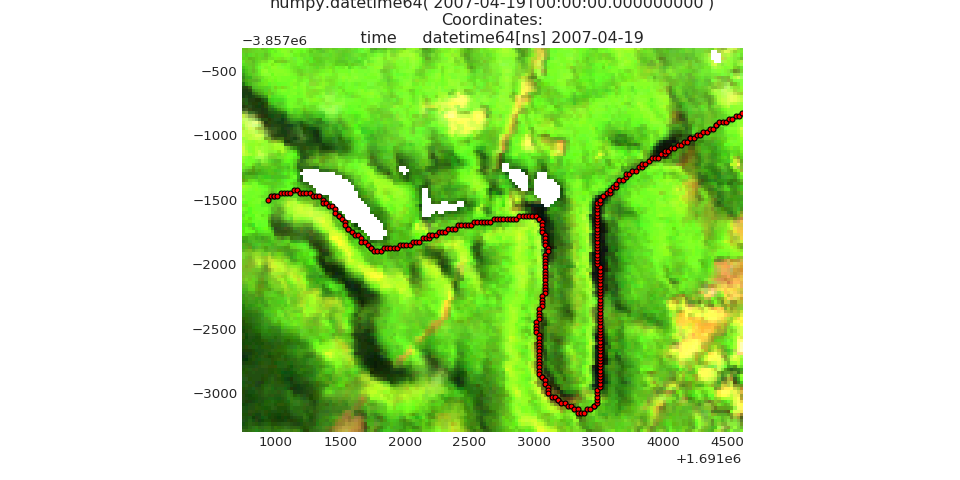

In [393]:
#Click on this image to chose the location for the Hovmoller extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')

plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

#plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)
date_ = nbar_clean.time[time_slice_i]
plt.title(date_.astype('datetime64[D]'))
plt.show()
display(w)

In [394]:
x, y

(1694046, -3858581)

In [414]:
#this converts the map x coordinate into image x coordinates
image_coords = ~nbar_clean.affine * (x, y)
imagex = int(image_coords[0])
imagey = int(image_coords[1])

<IPython.core.display.Javascript object>


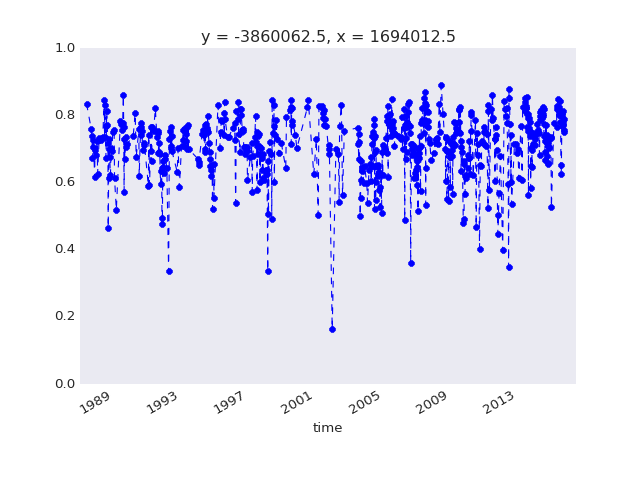

['1987-01-01', '2016-06-30', 0, 1]

In [415]:
#Use this plot to visualise TSS time series and select the image that corresponds with a point in the time series
def callback(event):
    global time_int, devent
    devent = event
    time_int = event.xdata
    #time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

fig = plt.figure()


fig.canvas.mpl_connect('button_press_event', callback)

plt.show()
display(w)

firstyear = '1987-01-01'
lastyear = '2016-06-30'
#all_nbr_sorted.isel(x=[imagex],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
all_ndvi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')

#water_only.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'm', marker = '8', mec = 'b', mfc ='m')
plt.axis([firstyear , lastyear ,0, 1])

In [397]:
time_slice = matplotlib.dates.num2date(time_int).date()
rgb = nbar_clean.sel(time =time_slice, method = 'nearest').to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 3000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled2 = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


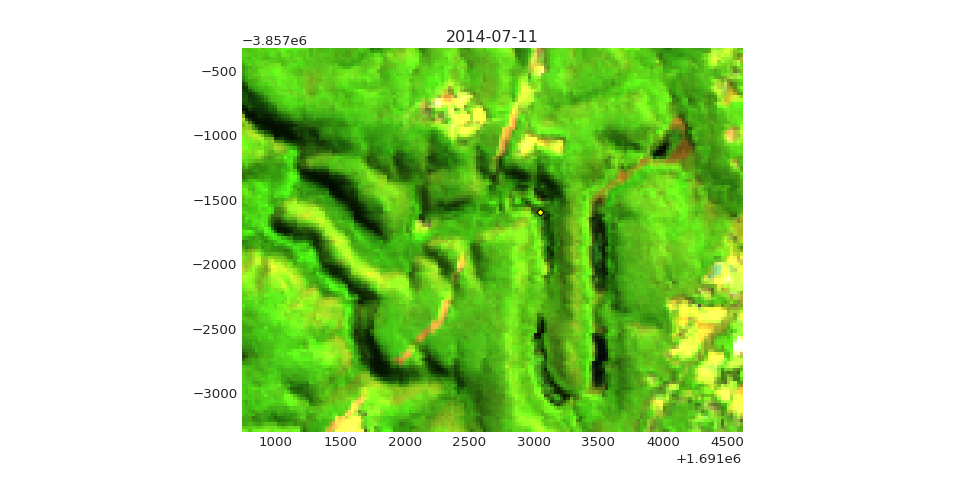

In [398]:
#Click on this image to chose the location for the Hovmoller extraction
w = widgets.HTML("Event information appears here when you click on the figure")


def callback(event):
    global x, y
    x, y = int(event.xdata + 0.5), int(event.ydata + 0.5)
    w.value = 'X: {}, Y: {}'.format(x,y)

fig = plt.figure(figsize =(12,6))
#plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')
plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')


plt.imshow(scaled2, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                   scaled.coords['y'].min(), scaled.coords['y'].max()])

#plt.grid(True)
fig.canvas.mpl_connect('button_press_event', callback)
plt.title(time_slice)
plt.show()

display(w)

<IPython.core.display.Javascript object>


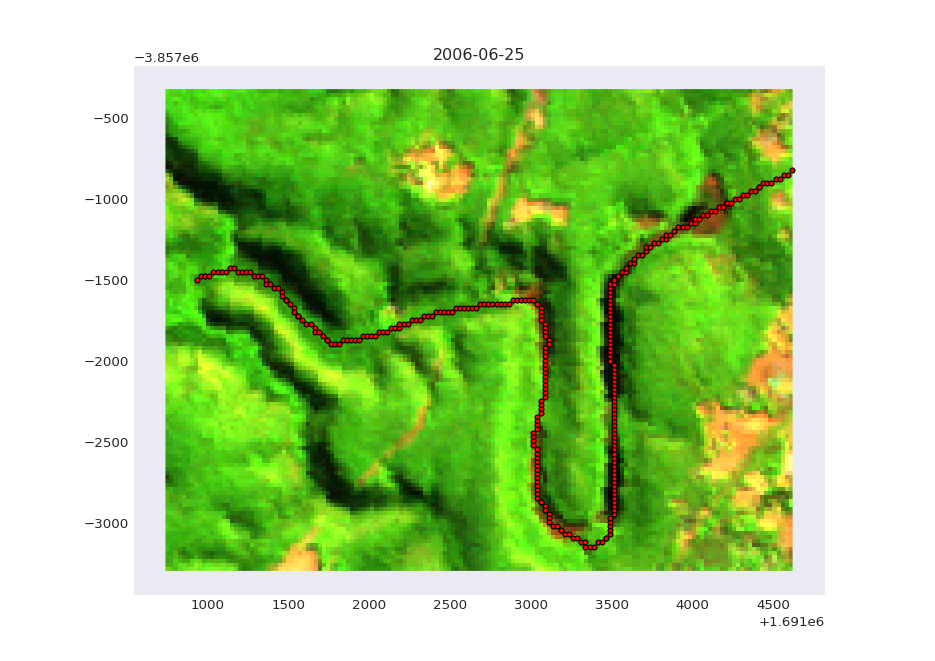

In [380]:
#if the figure above is the one you want to save to PDF use this cell
aoi = 'Thirlmere'
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + str(time_slice)+ '.pdf'
with PdfPages(out_fname) as pdf:
    #put the figure creation gumph in here
    fig = plt.figure(figsize =(11.69,8.27))
    plt.scatter(x = [x], y = [y], c= 'yellow', marker = 'D')

    plt.imshow(scaled2, interpolation = 'nearest',
               extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                       scaled.coords['y'].min(), scaled.coords['y'].max()])

    #plt.scatter(x=trans.coords['x'], y=trans.coords['y'], c='r')

    plt.title(time_slice)
    plt.show()
    pdf.savefig()


<IPython.core.display.Javascript object>


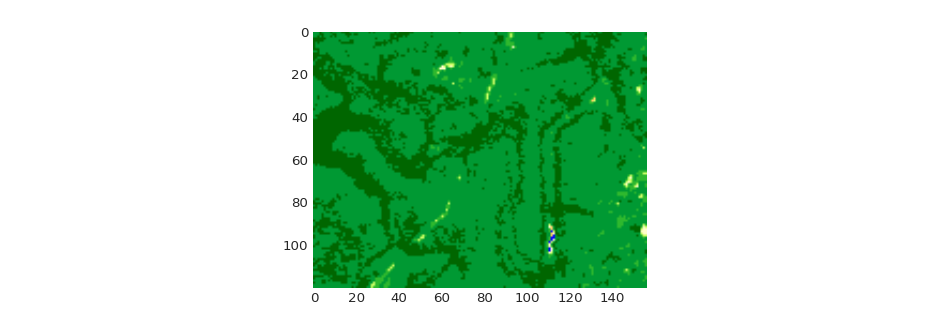

<xarray.DataArray 'time' ()>
numpy.datetime64('2007-04-19T00:00:00.000000000')
Coordinates:
    time     datetime64[ns] 2007-04-19


In [413]:
fig = plt.figure(figsize=(11.69,4))

#Define coordinates of interest
timeactual = all_ndvi_sorted.time[time_slice_i]

tss_min = 0
tss_max = 2000
plt.scatter(x=[x], y=[y], c='r')

plt.plot([0, all_ndvi_sorted.shape[2]], [y,y], 'r')
#plt.plot([x,x], [0, all_ndvi_sorted.shape[1]], 'aquamarine')

ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
tss_cmap = mpl.colors.ListedColormap(['navy', 'blue', 'deepskyblue','aquamarine' , 'burlywood' , 'saddlebrown'])
nbr_cmap = mpl.colors.ListedColormap(['darkslategray','dimgray' , 'lightgrey' , '#ccff66' , '#2eb82e', '#009933'])

#ndvi_bounds = [-1, 0, 0.1, 0.2, 0.3, 0.5, 0.8, 1]
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]

nbr_bounds = [-1, -0.1, 0, 0.1, 0.2, 0.4, 0.6]
tss_bounds = [0, 10, 20, 50, 80, 100, 150]

tss_norm = mpl.colors.BoundaryNorm(tss_bounds, tss_cmap.N)
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)
nbr_norm = mpl.colors.BoundaryNorm(nbr_bounds, nbr_cmap.N)

imshow(all_ndvi_sorted.sel(time = time_slice), cmap = ndvi_cmap, norm = ndvi_norm)
#imshow(all_nbr_sorted.isel(time = time_slice), cmap = nbr_cmap, norm = nbr_norm)


print timeactual.astype(datetime64)

In [401]:
# Set the percentage of good data that you'd like to display with pernan variable - 0.9 will return rows that have 90%
# of valid values
pernan = 0.9
geom_w = warp_geometry(geom, query['crs'], crs.wkt)
trans = transect(all_ndvi_sorted, geom_w, 25)
trans_drop = transect(all_ndvi_sorted, geom_w, 25).dropna('time', how = 'any', thresh = int(pernan*trans.shape[0]))

#You can check below to see the number of time slices dropped
print 'The number of time slices unfiltered = '+ str(trans.shape[1])
print 'The number of time slices filtered = ' + str(trans_drop.shape[1])

The number of time slices unfiltered = 995
The number of time slices filtered = 390


<IPython.core.display.Javascript object>


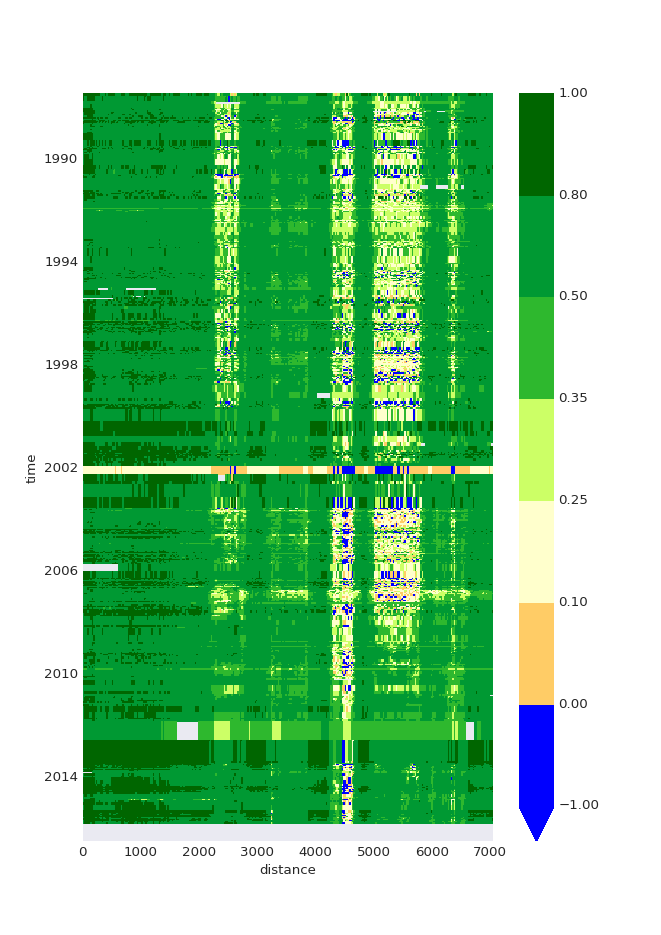

In [402]:
firstyearhov = '1987-06-01'
lastyearhov = '2016-06-30'
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + 'from' +str(firstyearhov)+'to'+str(lastyearhov)+'hovmoller.pdf'
with PdfPages(out_fname) as pdf:
    fig = plt.figure(figsize=(8.27,11.69))
    trans_drop.plot(x='distance', y='time', vmin = 0, vmax = 150, yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)
    plt.axis([0, trans_drop.distance.max(), lastyearhov , firstyearhov])
    pdf.savefig()

<IPython.core.display.Javascript object>


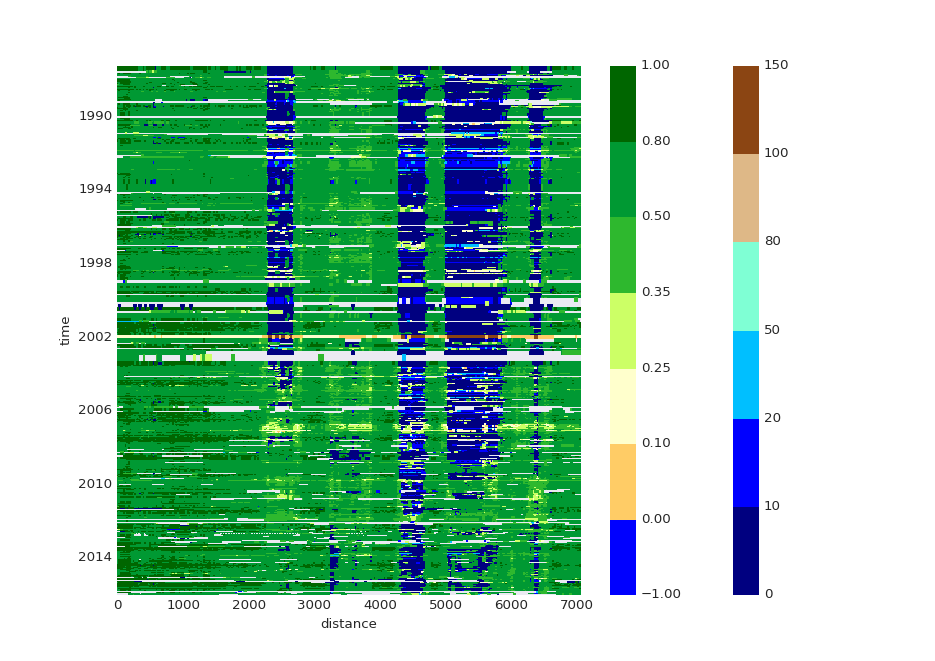

In [412]:
#This cell allows you to plot NDVI for terrestrial targets and TSS for aquatic targets in the same figure
fig = plt.figure(figsize=(11.69,8.27))

water_only = all_tss_sorted.where(nbar_clean['swir1']<500)
water_only.attrs['crs'] = crs
water_only.attrs['affine'] = affine
trans_water = transect(water_only, geom_w, 25).dropna('time', how = 'all')
trans_water.plot(x='distance', y='time', yincrease = False, cmap = tss_cmap, norm = tss_norm)



land_only = all_ndvi_sorted.where(nbar_clean['swir1']>500)
land_only.attrs['crs'] = crs
land_only.attrs['affine'] = affine
trans_land = transect(land_only, geom_w, 25).dropna('time', how = 'all')
trans_land.plot(x='distance', y='time', yincrease = False, cmap = ndvi_cmap, norm = ndvi_norm)


In [107]:
ts = all_ndwi_sorted.isel(x=[imagex],y=[imagey]).dropna('time', how = 'any')
#ts

<IPython.core.display.Javascript object>


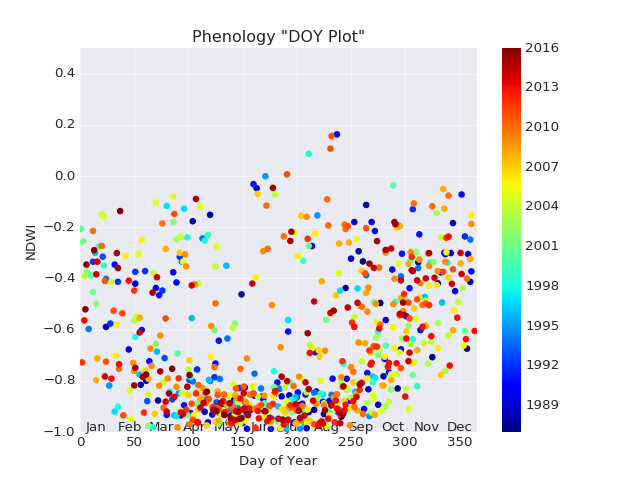

In [108]:

#This is the phenology stacking code from Chris Holden - Boston University
import datetime as dt
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('seaborn-dark')

#MEASUREMENT = 'nir'

# Given ``data`` is an xarray.Dataset with dimensions ('time', 'y', 'x')
pix = ts

fig, ax = plt.subplots()

# Grabbing the day of year (for xaxis) and year (for color) made easier with xarray
sp = ax.scatter(pix['time.dayofyear'], pix, c=pix['time.year'],
                cmap=mpl.cm.jet, marker='o', edgecolor='none', s=35)
fig.colorbar(sp)

# If you want the months to show up as minor ticks...
month_doys = [dt.date(2000, m, 15).timetuple().tm_yday for m in range(1, 13)]
months = mpl.ticker.FixedLocator(month_doys)
months_fmrt = mpl.dates.DateFormatter('%b')

ax.xaxis.set_ticks(month_doys, minor=True)
ax.tick_params(axis='x', which='minor', direction='in', pad=-10)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmrt)

# Labels and axis limits are good
ax.grid(True)
ax.set_xlim((0, 366))
ax.set_ylim((-1, 0.5))
ax.set_xlabel('Day of Year')
ax.set_ylabel('NDWI')
ax.set_title('Phenology "DOY Plot"')

In [ ]:
print nbar_clean.red.shape[0]




In [ ]:
#select time slice of interest
time_slice = 385
rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
#rgb = nbar_clean.isel(time =time_slice).to_array(dim='color').sel(color=['swir1', 'nir', 'green']).transpose('y', 'x', 'color')
date_ = nbar_clean.time[time_slice].values
print pd.to_datetime(date_).strftime('%Y-%m-%d')
fake_saturation = 6000
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [ ]:
fig = plt.figure(figsize=(11.69,5))
#plt.plot([x,x], [0, all_ndvi_sorted.shape[1]], 'aquamarine')
plt.plot([0, all_ndvi_sorted.shape[2]], [y,y], 'r')
plt.scatter(x=[imagex], y=[y], c='r')
plt.scatter(x=[imagex2], y=[y], c='b')


imshow(scaled)

In [ ]:
#scaled1 = scaled
#scaled2 = scaled
scaled3 = scaled

In [ ]:
#Select 3 time slices and populate the figure with them

time_slice = 2
time_slice2 = 242
time_slice3 = 484


date = nbar_clean.time[time_slice].values
date2 = nbar_clean.time[time_slice2].values
date3 = nbar_clean.time[time_slice3].values

fig = plt.figure(figsize=(11.69,8.27))
gs = gridspec.GridSpec(3, 2)
ax1 = plt.subplot(gs[0, 0])
ax1 = imshow(scaled1)
ax1 = title(pd.to_datetime(date).strftime('%Y-%m-%d'))
ax1 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax1 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax1 = plt.axis('image')
#ax1 = plt.plot([x,x], [0, all_ndvi_sorted.shape[1]], 'r')
ax1 = plt.plot([0, all_ndvi_sorted.shape[2]], [y,y], 'r')



ax2 = plt.subplot(gs[1, 0])
ax2 = imshow(scaled2)
ax2 = title(pd.to_datetime(date2).strftime('%Y-%m-%d'))
ax2 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax2 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')

ax3 = plt.subplot(gs[2, 0])
ax3 = imshow(scaled3)
ax3 = title(pd.to_datetime(date3).strftime('%Y-%m-%d'))
ax3 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax3 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')



ax4 = plt.subplot(gs[:,1])
ax4 = plt.grid(color = 'r', linestyle = '--')
#ax4 = imshow(rsindex_subs['NDWI'].as_matrix(range(3,len(rsindex_subs['NDVI'].columns))), aspect='auto', vmin=ndmin, vmax=ndmax)
ax4 = all_ndvi_sorted.isel(#x=[x],
                 y=[y]
                 ).plot(norm= ndvi_norm, cmap = ndvi_cmap, yincrease = False)



In [ ]:
#Select 3 time slices and populate the figure with them

"""time_slice = 4
time_slice2 = 264
time_slice3 = 522"""



date = nbar_clean.time[time_slice].values
date2 = nbar_clean.time[time_slice2].values
date3 = nbar_clean.time[time_slice3].values

fig = plt.figure(figsize=(11.69,8.27))
gs = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(gs[0, 0])
ax1 = imshow(scaled1)
ax1 = title(pd.to_datetime(date).strftime('%Y-%m-%d'))
ax1 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax1 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax1 = plt.axis('image')
#ax1 = plt.plot([x,x], [0, all_ndvi_sorted.shape[1]], 'r')
#ax1 = plt.plot([0, all_ndvi_sorted.shape[2]], [y,y], 'r')
ax1 = plt.scatter(x=[imagex], y=[y], c='r')
ax1 = plt.scatter(x=[imagex2], y=[y], c='b')

ax1 = plt.axis('image')



ax2 = plt.subplot(gs[0, 1])
ax2 = imshow(scaled2)
ax2 = title(pd.to_datetime(date2).strftime('%Y-%m-%d'))
ax2 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax2 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax2 = plt.scatter(x=[imagex], y=[y], c='r')
ax2 = plt.scatter(x=[imagex2], y=[y], c='b')

ax2 = plt.axis('image')

ax3 = plt.subplot(gs[0, 2])
ax3 = imshow(scaled3)
ax3 = title(pd.to_datetime(date3).strftime('%Y-%m-%d'))
ax3 = plt.tick_params(axis = 'y', which = 'both', left = 'off', right = 'off', labelright = 'off', labelleft= 'off')
ax3 = plt.tick_params(axis = 'x', which = 'both', bottom = 'off', top = 'off', labelbottom = 'off')
ax3 = plt.scatter(x=[imagex], y=[y], c='r')
ax3 = plt.scatter(x=[imagex2], y=[y], c='b')

ax3 = plt.axis('image')

plotfirstyear = '1987-01-01'
plotlastyear = '2016-12-31'

ax4 = plt.subplot(gs[1,:])
#ax4 = imshow(rsindex_subs['NDWI'].as_matrix(range(3,len(rsindex_subs['NDVI'].columns))), aspect='auto', vmin=ndmin, vmax=ndmax)
ax4 = all_ndvi_sorted.isel(x=[imagex],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'r', marker = '8', mec = 'b', mfc ='r')
ax4 = all_ndvi_sorted.isel(x=[imagex2],y=[y]).dropna('time', how = 'any').plot(linestyle= '--', c= 'b', marker = '8', mec = 'b', mfc ='b')

ax4 = plt.axis([plotfirstyear , plotlastyear ,0.1, 0.9])


In [ ]:
out_fname = '/g/data/r78/lxl554/hovmoller/' + aoi + '3image_NDVI.pdf'
with PdfPages(out_fname) as pdf:
    #put the figure creation gumph in here
    pdf.savefig()